In [1]:
import sys

sys.path.append("../")

## random walk

In [2]:
import json
import os
from pprint import pprint

from src.graph import TYPES_OF_GRAPH, Graph
from src.sample_dialogue import sample_dialogue

path = '../data'

input_path = os.path.join(path, 'theme_graph.json')
graph_dict = json.load(open(input_path, 'r'))
graph = Graph(graph_dict, TYPES_OF_GRAPH.DI)

sampled_dialogue, sampled_base_graph = sample_dialogue(
    graph.nx_graph,
    start_node=1,
    topic='books'
)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
False


In [3]:
pprint(sampled_base_graph)

{'edges': [{'source': 1,
            'target': 2,
            'theme': 'books',
            'utterances': ['I need a book.']},
           {'source': 2,
            'target': 3,
            'theme': 'books',
            'utterances': ["I'm interested in fiction."]},
           {'source': 3,
            'target': 5,
            'theme': 'books',
            'utterances': ['Do you have any mystery novels?']},
           {'source': 5,
            'target': 6,
            'theme': 'books',
            'utterances': ['I want to see the top books.']},
           {'source': 6,
            'target': 7,
            'theme': 'books',
            'utterances': ['Any recommendations for authors?']},
           {'source': 7,
            'target': 8,
            'theme': 'books',
            'utterances': ['Give me the details of this authour.']},
           {'source': 8,
            'target': 6,
            'theme': 'books',
            'utterances': ['No, I want to see other popular books.']},
    

In [4]:
pprint(sampled_dialogue)

[{'participant': 'assistant',
  'text': 'I am ready to help you choose a book, a movie, or a game.'},
 {'participant': 'user', 'source': 1, 'target': 2, 'text': 'I need a book.'},
 {'participant': 'assistant',
  'text': 'Would you like a fiction or a non-fiction book?'},
 {'participant': 'user',
  'source': 2,
  'target': 3,
  'text': "I'm interested in fiction."},
 {'participant': 'assistant', 'text': 'Which genre of fiction do you prefer?'},
 {'participant': 'user',
  'source': 3,
  'target': 5,
  'text': 'Do you have any mystery novels?'},
 {'participant': 'assistant', 'text': 'Bestsellers or something specific?'},
 {'participant': 'user',
  'source': 5,
  'target': 6,
  'text': 'I want to see the top books.'},
 {'participant': 'assistant', 'text': 'Check out these popular books.'},
 {'participant': 'user',
  'source': 6,
  'target': 7,
  'text': 'Any recommendations for authors?'},
 {'participant': 'assistant', 'text': 'Are there any authors you like?'},
 {'participant': 'user',
  

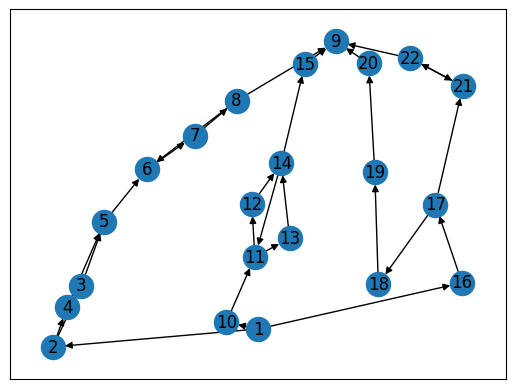

In [5]:
import networkx as nx

nx.draw_networkx(graph.nx_graph)

## all simple paths

In [6]:
paths_generator = nx.all_simple_edge_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)

In [7]:
paths

[[(1, 2), (2, 3), (3, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 2), (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)],
 [(1, 10), (10, 11), (11, 12), (12, 14), (14, 15), (15, 9)],
 [(1, 10), (10, 11), (11, 13), (13, 14), (14, 15), (15, 9)],
 [(1, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 9)],
 [(1, 16), (16, 17), (17, 21), (21, 22), (22, 9)]]

In [8]:
from src.sample_dialogue import materialize_dialogue

pprint(materialize_dialogue(graph.nx_graph, paths[-1]))

[{'participant': 'assistant',
  'text': 'Do you want to choose a book, a movie, or a game?'},
 {'participant': 'user', 'text': 'I need a video game recommendation.'},
 {'participant': 'assistant', 'text': "Sure, let's find a video game for you."},
 {'participant': 'user', 'text': "I'm interested in a specific genre of game."},
 {'participant': 'assistant', 'text': 'Which genre of games do you prefer?'},
 {'participant': 'user', 'text': "I want to know about the game's reviews."},
 {'participant': 'assistant',
  'text': 'What are the reviews like for this game?'},
 {'participant': 'user', 'text': 'What are the features of this game?'},
 {'participant': 'assistant',
  'text': "Can you tell me about the game's features?"},
 {'participant': 'user', 'text': 'Thanks for the recommendation!'},
 {'participant': 'assistant', 'text': 'Great choice!'}]


## simple cycles

In [9]:
all_cycles = nx.recursive_simple_cycles(graph.nx_graph)
all_cycles

[[6, 7, 8], [11, 12, 14], [11, 13, 14], [21, 22]]

In [10]:
paths_generator = nx.all_simple_paths(graph.nx_graph, source=1, target=9)
paths = list(paths_generator)
paths

[[1, 2, 3, 5, 6, 7, 8, 9],
 [1, 2, 4, 5, 6, 7, 8, 9],
 [1, 10, 11, 12, 14, 15, 9],
 [1, 10, 11, 13, 14, 15, 9],
 [1, 16, 17, 18, 19, 20, 9],
 [1, 16, 17, 21, 22, 9]]

In [11]:
from src.dialogue_sampling import add_cycles


add_cycles(graph.nx_graph, paths[5], n_cycles=1, n_repeats=[1])

[1, 16, 17, 21, 22, 21, 22, 9]